# **1. Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from matplotlib import pyplot
import seaborn as sns 
from PIL import Image
from glob import glob
import os 
import tqdm.notebook as tq 
import random  
import cv2 

import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D 
from tensorflow.keras.layers import BatchNormalization 

# **2. Data Exploration**

In [2]:
dir1 = '/kaggle/input/discwheel-classification-dataset-1'
dir2 = '/kaggle/input/discwheel-classification-dataset-2'
dir3 = '/kaggle/input/discwheel-classification-dataset-3'
dir4 = '/kaggle/input/discwheel-classification-dataset-4'

In [3]:
classes = set(os.listdir(dir1)+os.listdir(dir2)+os.listdir(dir3))
classes_labels = {subdir:i for i,subdir in enumerate(classes)}
num_classes = len(classes)
print(classes)
print(num_classes)

{'10K RUZGUL', 'BEY', '10K ELMAS', 'PS 5 KOL', '10K YILDIZ', 'SAR', 'PAR V KOL', 'PS 15 KOL', 'PS T KOL', '5K SIYTAS', 'PS Y KOL', 'PS 10 KOL', '20KOL FUME', '20KOL PAR', 'BUMERANK'}
15


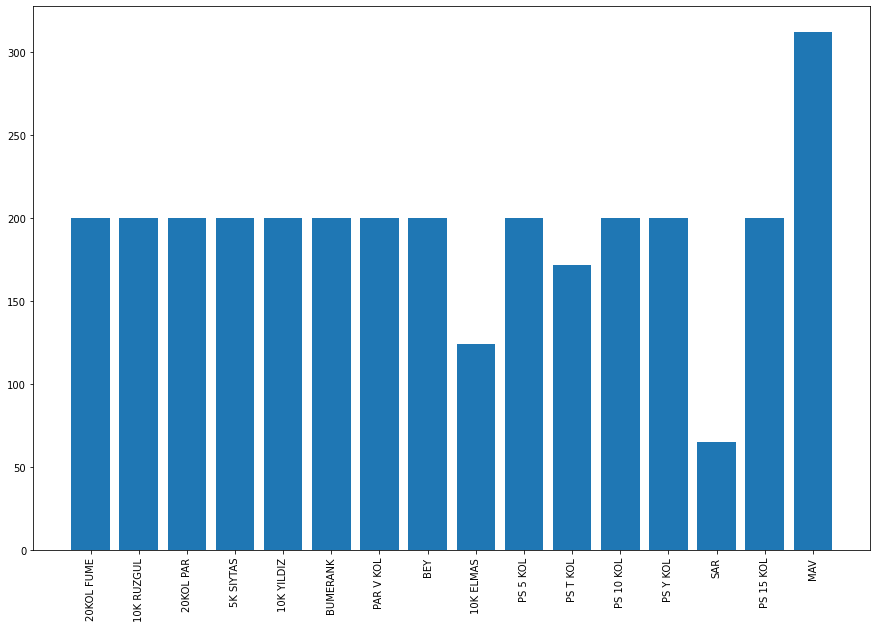

In [4]:
def plot_class_dist(*dir):
    directories = [*dir]
    graph_list = {"Width/Height Ratio":[],"Format":[],"Width":[],"Height":[]}
    model_classes = {}
    for directory in directories:
        for classes in os.listdir(directory):
            model_classes[classes]=0
    for directory in directories:
        for classes in os.listdir(directory):
            model_classes[classes]+=len(os.listdir(os.path.join(directory,classes)))
    
    plt.figure(figsize=(15,10))
    plt.bar(*zip(*model_classes.items()))
    var = plt.xticks(rotation=90) # Optional: If you have too much data, rotates labels
    plt.show()

plot_class_dist(dir1,dir2,dir3,dir4)

Total Number of images: 3073


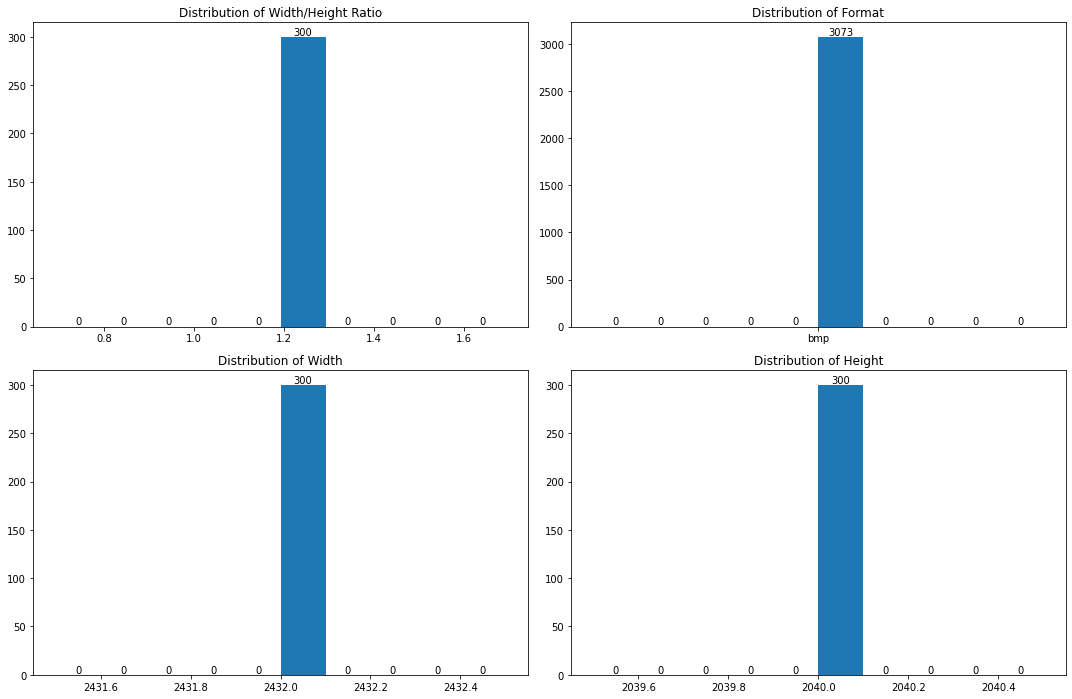

In [5]:
from glob import glob
import random
def plot_summary_graphs(*dir, num_samples=500):
    graph_list = {"Width/Height Ratio":[],"Format":[],"Width":[],"Height":[]}
    directories = [*dir]
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[])
    all_files = sum([glob(os.path.join(i,'**/*.*'), recursive=True) for i in directories],[])
    graph_list["Format"] = [fp.split('.')[-1] for fp in all_files]
    print('Total Number of images: %d'%len(images))
    samples = images if num_samples==0 else random.sample(images, num_samples)
    for image in samples:
        im = Image.open(image)
        graph_list["Width"].append(im.size[0])
        graph_list["Height"].append(im.size[1])
        graph_list["Width/Height Ratio"].append(im.size[0]/im.size[1])
    plt.figure(figsize=(15,10))
    for i,k in enumerate(graph_list):
        plt.subplot(2, 2, i+1)
        # ax = sns.countplot(x=graph_list[k])
        # ax.bar_label(ax.containers[0])
        counts, edges, bars = plt.hist(graph_list[k], align="mid")
        plt.bar_label(bars)
        # plt.hist(graph_list[k], histtype='stepfilled', align='mid')
        plt.title('Distribution of '+ k)
    plt.tight_layout()
    plt.ticklabel_format(useOffset=False) # Prevents scientific notation (e.g 1.28e3) 
    plt.show()

# set num_samples to 0 to check all dir
plot_summary_graphs(dir1,dir2,dir3,dir4, num_samples=300)

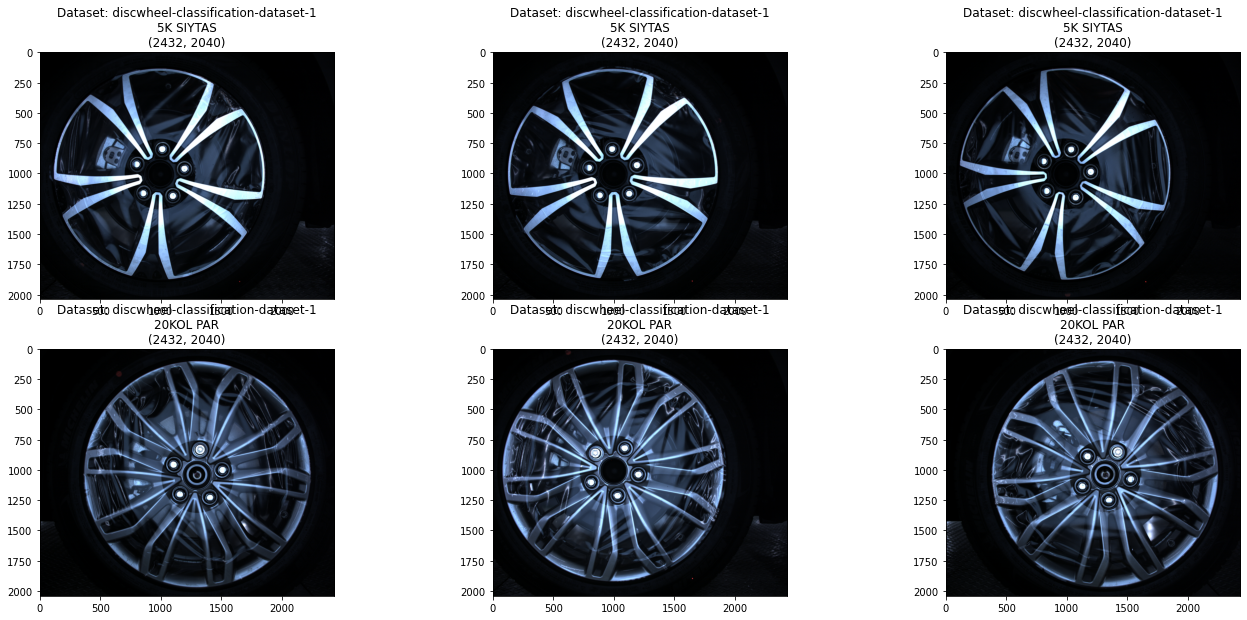

In [6]:
import random
def plot_images_subdirs(*dir, num_samp=5, num_cols=5, num_classes=3, gap=11): # num_classes=len(classes)
    i=0 
    directories = [*dir] 
    num_rows = int(num_samp*num_classes*len(directories)/num_cols)
    plt.figure(figsize=(23,num_classes*num_samp*gap/num_cols)) # increase 11 if image nest together
    for directory in directories:
        if num_classes>len(os.listdir(directory)): num_classes=len(os.listdir(directory))
        for folder in random.sample(os.listdir(directory), num_classes):
            for image in random.sample(os.listdir(os.path.join(directory,folder)),num_samp): 
                plt.subplot(num_rows,num_cols,i+1) 
                img = Image.open(os.path.join(directory,folder,image)) 
                plt.title("Dataset: " + directory.split("/")[-1] + "\n"+ folder + "\n" + str(img.size))
                plt.imshow(img) 
                i+=1
    plt.show()

plot_images_subdirs(dir1 ,num_samp=3, num_cols=3, num_classes=2, gap=5)

In [7]:
batch_size = 32
seed = 10
img_size = (224,224) # (width, height) - This will be the dimensions to load images!!!

# **3. Loading Data**

In [8]:
def fp_to_df(f_path):
    labels = []
    filepaths = []
    
    for folder in os.listdir(f_path):
        for image in os.listdir(os.path.join(f_path,folder)):
            labels.append(folder)
            filepaths.append(os.path.join(f_path,folder,image))
            
    filepath = pd.Series(filepaths, name="Filepath")
    label = pd.Series(labels, name="Label")
    
    df = pd.concat([label,filepath], axis=1)
    
    return df

In [9]:
df1 = fp_to_df(dir1)
df2 = fp_to_df(dir2)
df3 = fp_to_df(dir3)
df4 = fp_to_df(dir4)

# **4. Merging Seperate Sets**

In [10]:
df = pd.concat([df1, df2, df3, df4])
df = df.sample(frac=1).reset_index(drop=True) # Shuffle

# **5. Define Classes**

In [11]:
classes = np.unique(df["Label"], return_counts=True)[0].tolist()

In [12]:
print(classes)

['10K ELMAS', '10K RUZGUL', '10K YILDIZ', '20KOL FUME', '20KOL PAR', '5K SIYTAS', 'BEY', 'BUMERANK', 'MAV', 'PAR V KOL', 'PS 10 KOL', 'PS 15 KOL', 'PS 5 KOL', 'PS T KOL', 'PS Y KOL', 'SAR']


In [13]:
print(len(classes))

16


# **6. Generate Label Decoder & Category IDs**

In [14]:
label_decoder = {i:classes for i,classes in enumerate(classes)} # for General usage

label_encoder = {v: k for k, v in label_decoder.items()} # for General usage

category_ids = [i for i in label_decoder.keys()]

# **7. Exporatory Data Analysis**

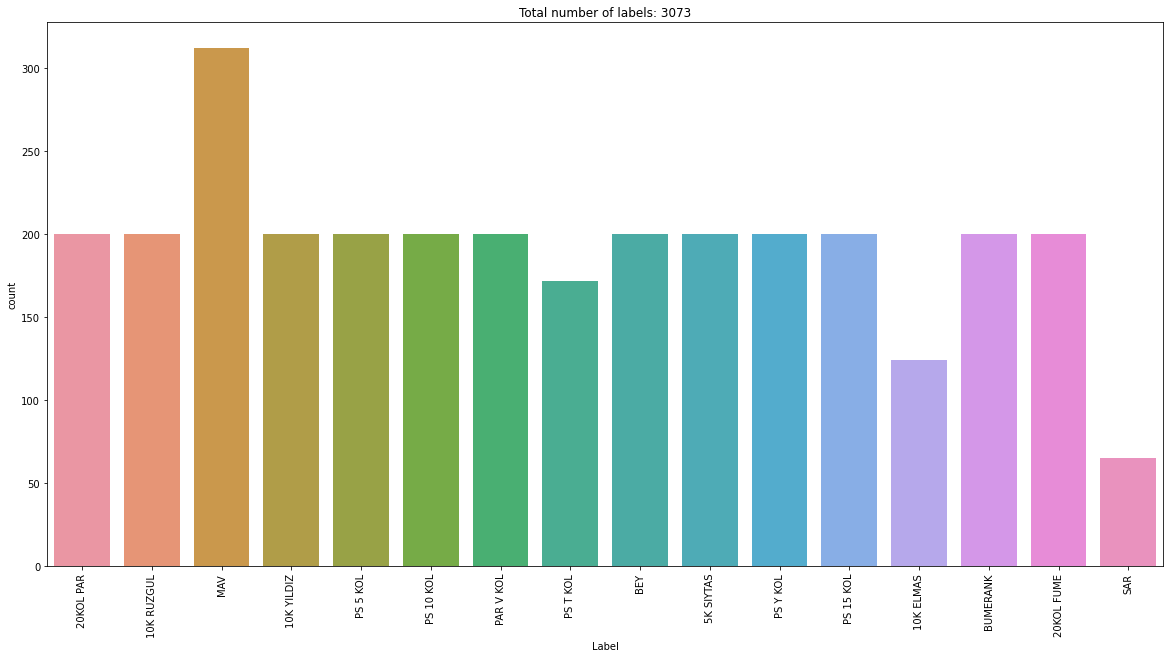

In [15]:
def plot_class_dist(*args):
    """
    Plot class distribution
    args: list or series of class labels
    """
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(len(args),1) # Create subplots & specify (#rows, #columns)
    gs.update(wspace=0.2, hspace=0.2) # Specify spaces between subplot (#rows, #columns)
    for i in range(len(args)):
        ax = fig.add_subplot(gs[i, 0]) # Place plot on a subplot [row,column]
        ax = sns.countplot(x=args[i]) # For Array, use x=y, to change orientation: "x=" → "y="
        ax.title.set_text(f"Total number of labels: {len(args[i])}")
        dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #If you have too much class, rotates x labels 

plot_class_dist(df["Label"])

In [16]:
# df = df.groupby('Label', as_index=False, group_keys=False).apply(lambda x: x.sample(min(80, len(x))))

In [17]:
# plot_class_dist(df["Label"])

# **8. Image Processing**

In [18]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=7e4fb7eff4bd2328911933a3fb89595b24f1901b923c989198b84ef99d25f8d5
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [19]:
import random
import imutils
import albumentations as A
import math
class ImageProcess:
    def __init__(self):
        pass
    
    @classmethod
    def preprocess(cls, x, im_size=[""], num_samples=0): 
        num_samples=len(x) if num_samples==0 else num_samples 
        if isinstance(x, pd.Series): 
            if im_size[0]=="": return print("You must specify image size") 
            x = [x.iloc[i] for i in range(len(x))] if num_samples==len(x) else [x.iloc[i] for i in random.sample(range(0, len(x)), num_samples)]  
            x = np.array([cv2.resize(np.asarray(Image.open(x[i]).convert('RGB')),im_size) for i in range(len(x))], dtype="uint8") 
        elif isinstance(x, list): 
            if im_size[0]=="": return print("You must specify image size") 
            x = [x[i] for i in range(len(x))] if num_samples==len(x) else [x[i] for i in random.sample(range(0, len(x)), num_samples)]  
            x = np.array([cv2.resize(np.asarray(Image.open(x[i]).convert('RGB')),im_size) for i in range(len(x))], dtype="uint8") 
        elif isinstance(x, np.ndarray): 
            x = [x[i] for i in range(len(x))] if num_samples==len(x) else [x[i] for i in random.sample(range(0, len(x)), num_samples)] 
            if im_size[0]!="": x = np.array([cv2.resize(x[i], im_size) for i in range(len(x))], dtype="uint8") 
        else: 
            print("There's a problem with your image data format") 
            return 
        return x,num_samples 
    
    @classmethod
    def plotOrReturn(cls, x, mode, num_samples, num_cols, plot_gap):
        if mode == "plot": 
            plt.figure(figsize=(23,num_samples*plot_gap)) 
            for i in random.sample(range(len(x)), num_samples): 
                plt.subplot(int(num_samples/num_cols)+1,num_cols,i+1) 
                plt.imshow(x[i-1]) 
            plt.show() 
        elif mode == "return": 
            return np.array(x, dtype="uint8") 
    
    @classmethod
    def just_plot(cls, x, num_samples=0, num_cols=5,plot_gap=1.3,im_size=[""], mode="plot"):
        """
        Doesn't make any change, useful for creating array, plotting original images, resizing or copying 
        x: Array containing images or dataframe column containing image paths 
        im_size= if specified as (width,height), resize image 
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        plot_gap: To increase image size or if images nest together, increase plot_gap size 
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """ 
        x,num_samples = cls.preprocess(x=x, im_size=im_size, num_samples=num_samples) 
        return cls.plotOrReturn(x, mode, num_samples, num_cols, plot_gap)
    
    @classmethod
    def save(cls, x, y=[""],z=[""], folder_name="dataset", sub_folder_name="images", im_size=[""], num_samples=0): 
        """ 
        Save images in given folder 
        x: Array containing images or dataframe column containing image paths 
        y: Array, list or DF column containing labels for each image (save images for each label folder) 
        z: Array, list or DF column containing names for each image (including format) 
        folder_name: Name of the folder to be created in current directory to save the images 
        sub_folder_name: Name of the folder to be created in folder_name to save the images 
        im_size= if specified as (width,height), resize image 
        """ 
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size) 

        if sub_folder_name==0: 
            if not os.path.exists(folder_name):os.mkdir(folder_name) 
        else: 
            if not os.path.exists(folder_name): os.mkdir(folder_name) 
            if not os.path.exists(os.path.join(folder_name,sub_folder_name)): os.mkdir(os.path.join(folder_name,sub_folder_name)) 
            folder_name = os.path.join(folder_name,sub_folder_name) 

        for i in range(len(x)): 
            if y[0] == '' and z[0] == '': # both z and y missing 
                pyplot.imsave(os.path.join(folder_name,f"image {i}.png"), x[i])
            elif z[0] == '': # only y exist 
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i])) 
                pyplot.imsave(os.path.join(folder_name,y[i],f"image {i}.png"), x[i])
            elif y[0] == '': # only z exist 
                pyplot.imsave(os.path.join(folder_name,z[i]), x[i])
            else: # both z and y exist 
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i])) 
                pyplot.imsave(os.path.join(folder_name,y[i],z[i]), x[i])
    
    @classmethod
    def grayscale(cls, x, num_samples=0, num_cols=5, mode="plot"):
        """ 
        Apply grayscale to images 
        x: Array containing images or dataframe column containing image paths 
        im_size= if specified as (width,height), resize image 
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        plot_gap: To increase image size or if images nest together, increase plot_gap size 
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """ 
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size) 
        set_new = []
        for img in x:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            set_new.append(img)
        return cls.plotOrReturn(set_new, mode, num_samples, num_cols, plot_gap)
        
    @classmethod
    def add_weighted_blur(cls, x, alpha=4, sigmaX=10, beta=-4, constant=128, im_size=[""], num_samples=0, num_cols=5, plot_gap=1.3, mode="plot"): 
        """ 
        Blend two images into one (original + blurred version) 
        x: Array containing images or dataframe column containing image paths 
        alpha: Try different parameters to find best results 
        sigmaX: Try different parameters to find best results 
        beta: Try different parameters to find best results 
        constant: Try different parameters to find best results 
        im_size= if specified as (width,height), resize image 
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        plot_gap: To increase image size or if images nest together, increase plot_gap size 
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """ 
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size)
        set_new = [] 

        for img in x: 
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
            img = cv2.addWeighted(img, alpha, cv2.GaussianBlur(img, (0,0), sigmaX), beta, constant) 
            set_new.append(img) 
        return cls.plotOrReturn(set_new, mode, num_samples, num_cols, plot_gap) 
    
    @classmethod
    def crop_from_gray(cls, x, im_size=(500,500), num_samples=0, num_cols=5, tol=7, plot_gap=1.3, mode="plot"): 
        """
        Crop image from gray areas after applying grayscale
        x: Array containing images or dataframe column containing image paths
        im_size(required)= After cropping, resize image as (width,height) 
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        tol: Tolerance. You may try different tolerances to find best parameter
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size) 
        set_new = []
        for img in x:
            if img.ndim ==2:
                img = cv2.resize(img, im_size)
                set_new.append(img)
            elif img.ndim==3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                mask = gray > tol
                check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
                if (check_shape == 0):
                    img = cv2.resize(img, im_size)
                    set_new.append(img)
                else:
                    img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                    img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                    img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                    img = np.stack([img1,img2,img3],axis=-1)
                img = cv2.resize(img, im_size)
                set_new.append(img)
        return ImageProcess.plotOrReturn(set_new, mode, num_samples, num_cols)
    
    @classmethod
    def circle_crop(cls, x, num_samples=0, im_size=(500,500), num_cols=5, plot_gap=1.3, mode="plot"):
        """
        Crop image to circle
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size) 
        set_new = []
        for img in x:
            height, width, depth = img.shape
            x = int(width/2)
            y = int(height/2)
            r = np.amin((x,y))
            circle_img = np.zeros((height, width), np.uint8)
            cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
            img = cv2.bitwise_and(img, img, mask=circle_img)
            img = cv2.resize(img, im_size)
            set_new.append(img)
        return cls.plotOrReturn(set_new, mode, num_samples, num_cols, plot_gap)
    
    @classmethod
    def circle_detection(cls, x, num_samples=0, im_size=[""], num_cols=5, plot_gap=1.3, mode="plot", blur_size=(3,3), param3=1, param4=250, param1=12, param2=11, minRadius=80, maxRadius=110, add_pixels=0):
        """
        Detects circles in the image
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        blur_size: Applies blur before trying to detect circles
        param3: It is usually 0.1 and try not to change it if not necessary
        param4: Lower the number, increases number of detected circles. Keep it high to detect only 1 circle
        param1: Try to pick best parameters by changing this parameter
        param2: Try to pick best parameters by changing this parameter
        minRadius: Detect circles with radius greater than this value
        maxRadius: Detect circles with radius lower than this value
        add_pixels: Before cropping, add some pixels from each side
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size)
        set_new = []
        detected_circles = []
        
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        for img in x:
            gray = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
            gray_blurred = cv2.blur(gray.copy(), blur_size)
            detected_circles = cv2.HoughCircles(gray_blurred.copy(), cv2.HOUGH_GRADIENT, param3, param4, 
                                        param1 = param1, param2 = param2, minRadius = minRadius, maxRadius = maxRadius)
            
            if detected_circles is not None:
                if len(detected_circles) == 0:
                    print(f"Cannot generate circle for image #{i}")
                    set_new.append(img)
                else:                
                    detected_circles = np.uint16(np.around(detected_circles))

                    if mode == "plot":
                        painted_img = img.copy()

                        for (x,y,r) in detected_circles[0, :]:
                            # Draw the circumference of the circle.
                            cv2.circle(painted_img, (x, y), r+add_pixels, (0, 255, 0), int(im_size[0]/80))

                            # Draw a small circle (of radius 1) to show the center.
                            cv2.circle(painted_img, (x, y), 1, (0, 0, 255), 3)
                        set_new.append(painted_img)

                    elif mode == "return":
                        # Append center location for each detected circle
                        detected_circles = detected_circles.tolist()
                        for array in detected_circles[0]:
                            array.append(int(math.sqrt(array[0]**2+array[1]**2)))

                        center_dist = [i[3] for i in detected_circles[0]]

                        # Find the circle closest to center
                        center_circle_idx = find_nearest(center_dist,int(math.sqrt(im_size[0]**2+im_size[1]**2)))
                        crop_coordinates = detected_circles[0][center_circle_idx]

                        # Crop the image from closest to center
                        top = crop_coordinates[1]+crop_coordinates[2]+add_pixels
                        bottom = crop_coordinates[1]-crop_coordinates[2]-add_pixels
                        left = crop_coordinates[0]-crop_coordinates[2]-add_pixels
                        right = crop_coordinates[0]+crop_coordinates[2]+add_pixels
                        if top>im_size[1]: top=im_size[1]
                        if bottom<=0: bottom = 0
                        if left<=0: left=0
                        if right>im_size[0]: right=im_size[0]
                        cropped_img = img[bottom:top, left:right].copy()
                        cropped_img = cv2.resize(cropped_img, (min(im_size),min(im_size)))
                        set_new.append(cropped_img)
            else:
                set_new.append(img)
                
        return cls.plotOrReturn(set_new, mode, num_samples, num_cols, plot_gap)
    
    @classmethod
    def contour_utils(cls, x, num_samples=0, im_size=(500,500), draw_mode="square_crop", ccr=300, num_cols=5, blur_size=(25,25), tresh_size=15, plot_gap=1.3, mode="plot"):  
        """
        Getting different version of the images after applying contour based on draw mode
        mode="plot"(default) -> Check contour detection & pick best parameters
        draw_mode="bg_contour" -> Draw red contour lines on white or black background
        draw_mode="bg_contour_cropped" -> Draw red contour lines on white or black background & crop from extreme points
        draw_mode="contour_filled" -> Fill contour are with specific color (black or white)
        draw_mode="contour_filled_reversed" -> Fill outside the contour are with specific color (black or white)
        draw_mode="contour_crop" -> Crop image from contour lines & fill the corners with color
        draw_mode="square_crop" -> Crop the image from contour extreme points
        draw_mode="contour_center_crop" -> Crop the image from the center of contours
        draw_mode="contour_center_crop_fill" -> Crop the image from the center of contours & fill the rest with black
        ccr: Center Crop Radius. It's used when cropping center of the contour
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples 
        im_size(required)= After cropping, resize image as (width,height)
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        blur_size: try different parameters to pick best blur size that crops perfectly 
        tresh_size: try different parameters to pick best tresh size that crops perfectly 
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size)
        set_new = []
        
        for img in x:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
            gray = cv2.GaussianBlur(gray, blur_size, 0) 
            # threshold the image, then perform a series of erosions +  
            # dilations to remove any small regions of noise  
            thresh = cv2.threshold(gray, tresh_size, 255, cv2.THRESH_BINARY)[1] 
            thresh = cv2.erode(thresh, None, iterations=2)  
            thresh = cv2.dilate(thresh, None, iterations=2)  
            thresh = thresh.astype(np.uint8)
            # find contours in thresholded image, then grab the largest one  
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
            cnts = imutils.grab_contours(cnts)  
            c = max(cnts, key=cv2.contourArea)
            # find the extreme points  
            extLeft = tuple(c[c[:, :, 0].argmin()][0])  
            extRight = tuple(c[c[:, :, 0].argmax()][0])  
            extTop = tuple(c[c[:, :, 1].argmin()][0])  
            extBot = tuple(c[c[:, :, 1].argmax()][0]) 
            
            # Create new image by drawing green contour on the image
            img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)
            # Add colorful circles to extreme points
            img_pnt = cv2.circle(img_cnt.copy(), extLeft, int(im_size[0]/30), (0, 0, 255), -1) 
            img_pnt = cv2.circle(img_pnt, extRight, int(im_size[0]/30), (0, 255, 0), -1) 
            img_pnt = cv2.circle(img_pnt, extTop, int(im_size[0]/30), (255, 0, 0), -1) 
            img_pnt = cv2.circle(img_pnt, extBot, int(im_size[0]/30), (255, 255, 0), -1) 
            
            if mode == "plot":
                set_new.append(img_pnt)
            elif mode == "return" and draw_mode == "bg_contour":
                # or np.zeros(image.shape, np.uint8) for black background
                bg = np.ones(img.shape, np.uint8) * 255 
                bg_cnt = cv2.drawContours(bg.copy(), [c], -1, (255, 0, 0), 4)
                set_new.append(bg_cnt)
            elif mode == "return" and draw_mode == "bg_contour_cropped":
                # or np.zeros(image.shape, np.uint8) for black background
                bg = np.ones(img.shape, np.uint8) * 255 
                bg_cnt = cv2.drawContours(bg.copy(), [c], -1, (255, 0, 0), 4)
                bg_cnt_cropped = bg_cnt[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
                bg_cnt_cropped = cv2.resize(bg_cnt_cropped, im_size)
                set_new.append(bg_cnt_cropped)
            elif mode == "return" and draw_mode == "contour_filled":
                # (0, 0, 0) -> (255, 255, 255) for white fill
                cnt_filled = cv2.drawContours(img.copy(), [c], -1, (0, 0, 0), -1)
                set_new.append(cnt_filled)
            elif mode == "return" and draw_mode == "contour_filled_reversed":
                mask = np.zeros_like(img)
                cv2.drawContours(mask, [c], 0, (255,255,255), -1)
                # apply mask to input image
                new_image = cv2.bitwise_and(img.copy(), mask)
                
                set_new.append(new_image)
            elif mode == "return" and draw_mode == "contour_crop":
                x,y,w,h = cv2.boundingRect(c)
                # draw filled contour on black background
                mask = np.zeros_like(img)
                cv2.drawContours(mask, [c], 0, (255,255,255), -1)
                # apply mask to input image
                new_image = cv2.bitwise_and(img.copy(), mask)
                # crop & resize
                ROI = new_image[y:y+h, x:x+w]
                ROI = cv2.resize(ROI, im_size)
                set_new.append(ROI)
            elif mode == "return" and draw_mode == "square_crop":
                # crop & resize the image
                new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()  
                new_img = cv2.resize(new_img, im_size)
                set_new.append(new_img)
            elif mode == "return" and draw_mode == "contour_center_crop":
                mid_x = int((extRight[0]-extLeft[0])/2)+extLeft[0]
                mid_y = int((extTop[1]-extBot[1])/2)+extBot[1]
                ROI = img[mid_y-ccr:mid_y+ccr, mid_x-ccr:mid_x+ccr].copy()
                set_new.append(ROI)
            elif mode == "return" and draw_mode == "contour_center_crop_fill":
                mask = np.zeros(img.shape, dtype=np.uint8)
                mid_x = int((extRight[0]-extLeft[0])/2)+extLeft[0]
                mid_y = int((extTop[1]-extBot[1])/2)+extBot[1]
                cv2.circle(mask, (mid_x,mid_y), ccr, (255,255,255), -1)
                ROI = cv2.bitwise_and(img.copy(), mask)
                set_new.append(ROI)
            
        return cls.plotOrReturn(set_new, mode, num_samples, num_cols, plot_gap)
    
    @classmethod
    def hsv(cls, x, num_samples=0, num_cols=5, hue=0, sat=150, brt=0, im_size=[""], plot_gap=1.3, mode="plot"):
        """  
        Apply hsv to image. hue_shift changes color, sat_shift changes extremes.
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        hue_shift: try different parameters to pick best color 
        sat_shift: try different parameters to pick best extremes 
        brt: brightness parameter
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,num_samples = cls.preprocess(x=x, im_size=im_size, num_samples=num_samples)
        
        transform = A.Compose([
            A.HueSaturationValue(p=1.0, hue_shift_limit=(hue, hue), sat_shift_limit=(sat, sat), val_shift_limit=(brt, brt))
        ])
            
        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])
                
        x_aug = np.array(x_aug)
        
        return cls.plotOrReturn(x_aug, mode, num_samples, num_cols, plot_gap)
    
    @classmethod
    def solarize(cls, x, num_samples=0, num_cols=5, tresh=150, im_size=[""], plot_gap=1.3, mode="plot"):
        """  
        Apply solarize to image.
        Last parameter is brightness so no need to change.
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        tresh: try different parameters to pick best extremes
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size)
        
        transform = A.Compose([A.Solarize(p=1.0, threshold=(tresh, tresh))])
            
        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])
                
        x_aug = np.array(x_aug)
        
        return cls.plotOrReturn(x_aug, mode, num_samples, num_cols, plot_gap)
    
    @classmethod
    def clahe(cls, x, num_samples=0, num_cols=5, clip=15, tile=23, im_size=[""], plot_gap=1.3, mode="plot"):
        """  
        Apply solarize to image.
        Last parameter is brightness so no need to change.
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        clip: try different parameters to pick best parameter
        tile: try different parameters to pick best parameter
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,num_samples = cls.preprocess(x=x, num_samples=num_samples, im_size=im_size)
        
        transform = A.Compose([A.CLAHE(p=1.0, clip_limit=(clip, clip), tile_grid_size=(tile, tile))])
            
        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])
                
        x_aug = np.array(x_aug)
        return cls.plotOrReturn(x_aug, mode, num_samples, num_cols, plot_gap)
    
    @classmethod
    def brightness_contrast(cls, x, num_samples=0, num_cols=5, brt=-0.6, cnt=0.8, im_size=[""], plot_gap=1.3, mode="plot"):
        """  
        Change contrast & brightness of the image
        Last parameter is brightness so no need to change.
        x: Array containing images or dataframe column containing image paths
        num_samples: If x is too large, you may only crop & plot few random samples 
        num_cols: Column size while plotting. Set it 2 or 3 to see more details 
        brt: try different parameters to pick best brightness
        cnt: try different parameters to pick best contrast
        im_size= if specified as (width,height), resize image
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs 
        """
        x,num_samples = cls.preprocess(x, im_size, num_samples)
    
        transform = A.Compose([
            A.RandomBrightnessContrast(p=1.0, brightness_limit=(brt, brt), contrast_limit=(cnt, cnt), brightness_by_max=True)
        ])
            
        x_aug = [] 
        for i in range(len(x)):
            image = x[i].copy()
            transformed = transform(image=image)
            if np.isnan(transformed['image']).any() or transformed['image'].max() > 255: 
                continue
            else:
                x_aug.append(transformed['image'])
                
        x_aug = np.array(x_aug)
        return cls.plotOrReturn(x_aug, mode, num_samples, num_cols, plot_gap)
# blur_size=(5,5), param3=0.01, param4=265, param1=35, param2=5, minRadius=80, maxRadius=130 → Almost perfect
# blur_size=(5,5), param3=0.01, param4=265, param1=35, param2=15, minRadius=80, maxRadius=130 → Almost perfect
# blur_size=(5,5), param3=0.01, param4=265, param1=35, param2=25, minRadius=80, maxRadius=130 → Almost perfect
# blur_size=(5,5), param3=0.01, param4=265, param1=35, param2=35, minRadius=80, maxRadius=130 → Almost perfect
# blur_size=(5,5), param3=0.01, param4=265, param1=31, param2=7, minRadius=80, maxRadius=130 → MOST PERFECT ONE YET
# im_size=(270, 224), blur_size=(5,5), param3=0.01, param4=265, param1=29, param2=11, minRadius=80, maxRadius=135 → EVEN MOST PERFECT ONE YET

In [20]:
# ImageProcess.circle_detection(df[df["Label"] == "SAR"]["Filepath"], im_size=(270, 224), blur_size=(5,5), param3=0.01, param4=265, param1=29, param2=11, minRadius=80, maxRadius=135, num_cols=4,plot_gap=1.4)

In [21]:
# ImageProcess.circle_detection(df["Filepath"], num_samples=240, im_size=(270, 224), blur_size=(3,3), param3=0.1, param4=255, param1=12, param2=11, minRadius=80, maxRadius=112, num_cols=4,plot_gap=1, add_pixels=15)

In [22]:
# # Make trial with dark images
# dark = ImageProcess.brightness_contrast(df[df["Label"] == "SAR"]["Filepath"], num_samples=61, num_cols=4,plot_gap=2,im_size=(270, 224),brt=-0.05, cnt=0.2, mode='return')

In [23]:
# # Make trial with shiny images
# shiny = ImageProcess.brightness_contrast(df[df["Label"] == "SAR"]["Filepath"],num_samples=61,num_cols=4,plot_gap=2,im_size=img_size,brt=0.2, cnt=1, mode="return")

In [24]:
# # Make trial with actual images
# actuals = ImageProcess.circle_detection(df[df["Label"] == "PS 10 KOL"]["Filepath"], im_size=(270, 224), blur_size=(5,5), param3=0.01, param4=265, param1=29, param2=11, minRadius=80, maxRadius=135, add_pixels=15, mode="return")

In [25]:
# ImageProcess.just_plot(actuals)

In [26]:
# # Enter dark or shiny
# ImageProcess.circle_detection(shiny, im_size=(270, 224), blur_size=(5,5), param3=0.01, param4=265, param1=29, param2=11, minRadius=80, maxRadius=135)

In [27]:
# ImageProcess.circle_detection(df[df["Label"] == "20KOL PAR"]["Filepath"],plot_gap=1, im_size=(270, 224), blur_size=(3,3), param3=1, param4=250, param1=12, param2=11, minRadius=80, maxRadius=110, add_pixels=15)

In [28]:
x = ImageProcess.circle_detection(df["Filepath"], im_size=(270, 224), blur_size=(5,5), param3=0.01, param4=265, param1=29, param2=11, minRadius=80, maxRadius=135, add_pixels=15, mode="return")

In [29]:
# x = ImageProcess.hsv(x, mode="return")

In [30]:
# ImageProcess.just_plot(x, num_samples = 160,plot_gap=1)

In [31]:
y = np.array(df["Label"])

# **9. Label Encoding Of Training, Test & Validation Labels**

In [32]:
from sklearn.preprocessing import OneHotEncoder 
ohe = OneHotEncoder(sparse=False) 
y = y.reshape(len(y), 1) 
y = ohe.fit_transform(y)

# **10. Splitting Data Into Training, Test & Validation Sets**

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, shuffle = True, random_state = 8) 
# x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.25, shuffle = True, random_state = 8)

# # For one hot decoded labels, y_train -> [label_decoder[y_train[i].argmax()] for i in range(len(y_train))]
# _, train_counts = np.unique([label_decoder[y_train[i].argmax()] for i in range(len(y_train))], return_counts=True) # Directory Iterator: xy_train.classes
# _, val_counts = np.unique([label_decoder[y_test[i].argmax()] for i in range(len(y_test))], return_counts=True) # Directory Iterator: xy_val.classes
# _, test_counts = np.unique([label_decoder[y_val[i].argmax()] for i in range(len(y_val))], return_counts=True) # Directory Iterator: xy_test.classes

# pd.DataFrame({'train': train_counts,'val': val_counts, 'test': test_counts},index=classes).plot.bar() 
# plt.show()

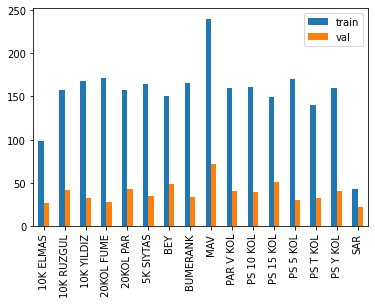

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.20, shuffle = True, random_state = 8) 

# For one hot decoded labels, y_train -> [label_decoder[y_train[i].argmax()] for i in range(len(y_train))]
_, train_counts = np.unique([label_decoder[y_train[i].argmax()] for i in range(len(y_train))], return_counts=True) # Directory Iterator: xy_train.classes
_, val_counts = np.unique([label_decoder[y_val[i].argmax()] for i in range(len(y_val))], return_counts=True) # Directory Iterator: xy_val.classes

pd.DataFrame({'train': train_counts,'val': val_counts},index=classes).plot.bar() 
plt.show()

# **11. Data Augmentation Of Training Data**

In [36]:
import albumentations as A

def plot_augmentations_for_single_image(image, num_cols=5, gap=1.1):
    chosen_image = image.copy()

    albumentation_list = [
        A.Affine(always_apply=False, p=1),
        A.AdvancedBlur(always_apply=False, p=1, blur_limit=(5, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)),
        A.Blur(always_apply=False, p=1.0, blur_limit=(5, 7)),
        A.CenterCrop(always_apply=False, p=1.0, height=150, width=150),
        A.ChannelDropout(always_apply=False, p=1.0, channel_drop_range=(1, 2), fill_value=0),
        A.ChannelShuffle(always_apply=False, p=1.0),
        A.CLAHE(always_apply=False, p=1.0, clip_limit=(13, 21), tile_grid_size=(23, 10)),
        A.ColorJitter(always_apply=False, p=1.0, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.Crop(always_apply=False, p=1.0, x_min=0, y_min=0, x_max=112, y_max=224),
        A.CropAndPad(p=1, percent=0.2),
        A.CoarseDropout(always_apply=False, p=1.0, max_holes=30, max_height=15, max_width=15, min_holes=None, min_height=None, min_width=None, fill_value=0),
        A.Downscale(always_apply=False, p=1.0, scale_min=0.45, scale_max=0.46, interpolation=0),
        A.Equalize(always_apply=False, p=1.0, mode='cv', by_channels=True),
        A.ElasticTransform(always_apply=False, p=1.0, alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None),
        A.FancyPCA(always_apply=False, p=1.0, alpha=0.1),
        A.Flip(always_apply=False, p=1), # Flip either horizontally, vertically or both horizontally and vertically.
        A.GaussNoise(always_apply=False, p=1.0, var_limit=(150.0, 350.0), per_channel=True, mean=0.0),
        A.GaussianBlur(always_apply=False, p=1.0, blur_limit=(5, 7), sigma_limit=0),
        A.GlassBlur(always_apply=False, p=1.0, sigma=0.7, max_delta=1, iterations=2),
        A.GridDistortion(always_apply=False, p=1.0, num_steps=5, distort_limit=0.8, interpolation=1, border_mode=4),
        A.GridDropout(always_apply=False, p=1.0, ratio=0.5, unit_size_min=10, unit_size_max=10, holes_number_x=10, holes_number_y=10, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None),
        A.HorizontalFlip(always_apply=False, p=1),
        A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(40, 50), sat_shift_limit=(20, 157), val_shift_limit=(-20, 50)),
        A.ISONoise(always_apply=False, p=1.0, intensity=(0.1, 0.5), color_shift=(0.25, 0.85)),
        A.MedianBlur(always_apply=False, p=1.0, blur_limit=7),
        A.MotionBlur(always_apply=False, p=1.0, blur_limit=(11, 13)),
        A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(0.6, 1.7), per_channel=True, elementwise=True),
        A.OpticalDistortion(always_apply=False, p=1.0, distort_limit=0.4, shift_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None),
        A.Perspective(always_apply=False, p=1.0, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1),
        A.PiecewiseAffine(always_apply=False, p=1),
        A.PixelDropout(always_apply=False, p=1, dropout_prob=0.05, drop_value=0),
        A.Posterize(always_apply=False, p=1.0, num_bits=[(0, 5), (0, 8), (0, 6)]),
        A.RandomBrightness(always_apply=False, p=1.0, limit=(-0.6, 0.6)),
        A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.6, 0.6), contrast_limit=(-0.6, 0.6), brightness_by_max=True),
        A.RandomContrast(always_apply=False, p=1.0, limit=(-0.6, 0.6)),
        A.RandomCrop(always_apply=False, p=1, height=200, width=200),
        A.RandomFog(always_apply=False, p=1.0, fog_coef_lower=0.22, fog_coef_upper=0.38, alpha_coef=1.0),
        A.RandomGamma(always_apply=False, p=1.0, gamma_limit=(35, 150), eps=None),
        A.RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3)),
        A.RandomRain(always_apply=False, p=1.0, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None),
        A.RandomResizedCrop(always_apply=False, p=1.0, height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0),
        A.RandomRotate90(always_apply=False, p=1.0),
        A.RandomShadow(always_apply=False, p=1.0, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5),
        A.RandomSnow(always_apply=False, p=1.0, snow_point_lower=0.1, snow_point_upper=0.8, brightness_coeff=2.5),
        A.RandomSunFlare(always_apply=False, p=1),
        A.RandomToneCurve(always_apply=False, p=1, scale=0.8),
        A.Resize(always_apply=False, p=1, height=500, width=500), # You normally don't need, but keep it just in case
        A.RGBShift(always_apply=False, p=1.0, r_shift_limit=(29, 20), g_shift_limit=(-20, 150), b_shift_limit=(-20, 150)),
        A.RingingOvershoot(always_apply=False, p=1.0, blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966)),
        A.Rotate(always_apply=False, p=1.0, limit=(-90, 90), crop_border=False),
        A.SafeRotate(always_apply=False, p=1),
        A.Sharpen(always_apply=False, p=1, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
        A.ShiftScaleRotate(always_apply=False, p=1.0, rotate_limit=(-90, 90),rotate_method='largest_box'),
        A.Solarize(always_apply=False, p=1.0, threshold=(150, 150)),
        A.Superpixels(always_apply=False, p=1.0, p_replace=0.1, n_segments=100, max_size=128, interpolation=1),
        A.Transpose(always_apply=False, p=1.0),
        A.ToGray(always_apply=False, p=1.0), # Might come in handy later, don't use!
        A.ToSepia(always_apply=False, p=1.0),
        A.VerticalFlip(always_apply=False, p=1.0)]

    titles_list = ["Original","Affine", "AdvancedBlur", "Blur","CenterCrop","ChannelDropout",
                   "ChannelShuffle", "CLAHE", "ColorJitter","Crop","CropAndPad", "CoarseDropout", 
                   "Downscale", "ElasticTransform","Equalize", "FancyPCA", "Flip", "GaussNoise", 
                   "GaussianBlur", "GlassBlur", "GridDistortion", "GridDropout","HorizontalFlip", 
                   "HueSaturationValue", "ISONoise", "MedianBlur","MotionBlur","MultiplicativeNoise", 
                   "OpticalDistortion" , "Perspective","PiecewiseAffine", "PixelDropout", "Posterize",
                   "RandomBrightness", "RandomBrightnessContrast", "RandomContrast","RandomCrop", 
                   "RandomFog", "RandomGamma", "RandomGridShuffle","RandomRain", "RandomResizedCrop", 
                   "RandomRotate90", "RandomShadow", "RandomSnow", "RandomSunFlare", "RandomToneCurve",
                   "Resize", "RGBShift", "RingingOvershoot", "Rotate", "SafeRotate", "Sharpen", "ShiftScaleRotate", 
                   "Solarize", "Superpixels","Transpose", "ToGray", "ToSepia", "VerticalFlip" ]
    img_matrix_list = []
    for aug_type in albumentation_list:
        img = aug_type(image = chosen_image)['image']
        img_matrix_list.append(img)
    img_matrix_list.insert(0,chosen_image)
    plt.figure(figsize=(20,len(titles_list)*gap)) # Increase 1.1 if images nested together
    for i, (img, title) in enumerate(zip(img_matrix_list, titles_list)):
        plt.subplot(int(len(titles_list)/num_cols)+1,num_cols,i+1)
        plt.title(title, fontsize=15)
        plt.imshow(img)

In [37]:
# plot_augmentations_for_single_image(x_train[175], 5, 1.1) # image, num_columns, gap of height for each row

In [38]:
import albumentations as A
def albumentations_aug(image):
    aug = A.Compose([
        A.SomeOf([
            A.Affine(always_apply=False, p=0.5),
            A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 5), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)),
            A.Blur(always_apply=False, p=0.5, blur_limit=(3, 5)),
            A.CropAndPad(p=0.5, percent=0.2),
            A.CoarseDropout(always_apply=False, p=0.5, max_holes=20, max_height=15, max_width=15, min_holes=None, min_height=None, min_width=None, fill_value=0),
            A.Downscale(always_apply=False, p=0.5, scale_min=0.70, scale_max=0.80, interpolation=0),
            A.Flip(always_apply=False, p=0.5),
            A.GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 5), sigma_limit=0),
            A.GlassBlur(always_apply=False, p=0.5, sigma=0.7, max_delta=1, iterations=2),
            A.HorizontalFlip(always_apply=False, p=0.5),
            A.MotionBlur(always_apply=False, p=0.5, blur_limit=(5, 7)),
            A.Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1),
            A.PixelDropout(always_apply=False, p=0.5, dropout_prob=0.05, drop_value=0),
            A.RandomCrop(always_apply=False, p=0.5, height=224, width=224),
            A.RandomGamma(always_apply=False, p=0.5, gamma_limit=(99, 100), eps=None),
            A.RandomResizedCrop(always_apply=False, p=0.5, height=224, width=224, scale=(0.1, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0),
            A.Transpose(always_apply=False, p=0.5),
            A.VerticalFlip(always_apply=False, p=0.5),
            A.RandomResizedCrop(always_apply=False, p=0.5, height=224, width=224, scale=(0.6, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0),
            ], 1, replace=True, p=0.5)
            ])
    return aug(image=image)['image']

In [39]:
from keras.preprocessing.image import ImageDataGenerator
# Loading + Augmentation Function For Training Data 
data_generator = ImageDataGenerator(
        rescale=1./255, # Normalize pixels while loading
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        brightness_range=[0.5,1.5], # 0: no brightness (full black), 1: no change, above 1: brighter
        rotation_range=180, # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = [0.9,1.0], # Randomly zoom image
#         width_shift_range=0.01, # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.01, # randomly shift images vertically (fraction of total height)
#         shear_range=0.01,
#         fill_mode='nearest', # "constant", "nearest", "reflect" or "wrap" - most popular: "nearest"
        horizontal_flip=True, # randomly flip images
        vertical_flip=True, # randomly flip images
        preprocessing_function = albumentations_aug,
) # preprocessing_function = albumentations_aug

In [40]:
# Load (x_train, y_train)
xy_train = data_generator.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=True, # (default: True) For training data, it must be True
    seed=seed,
) # Only used if validation_split is set !!!

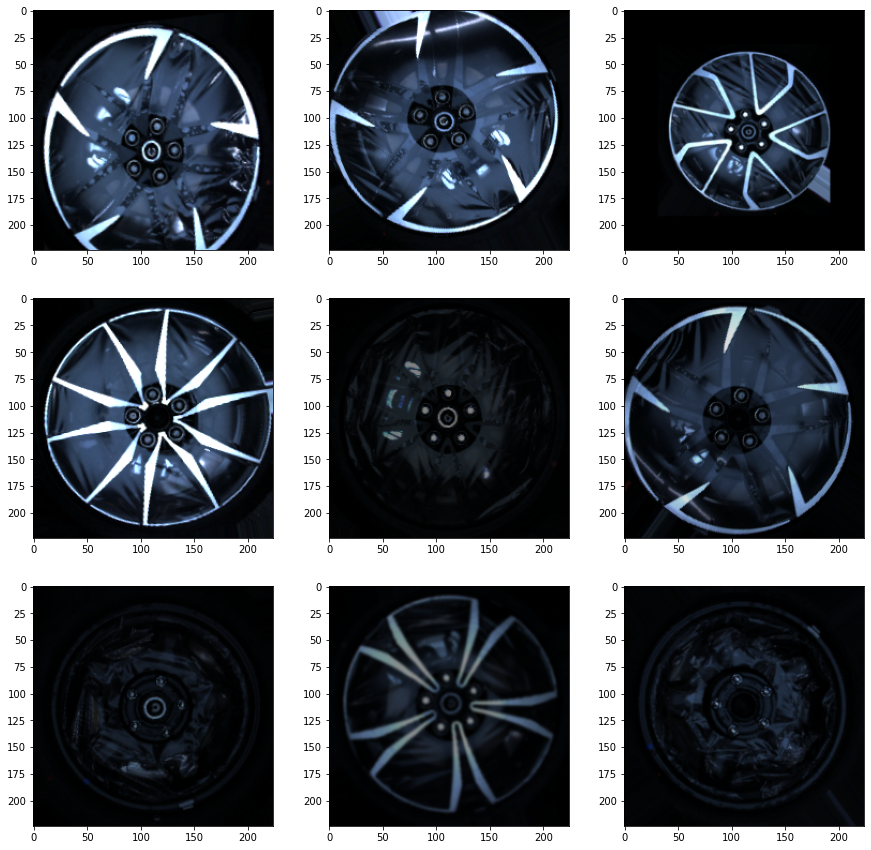

In [41]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = xy_train.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

# **12. Feature Scaling For Training, Test & Validation Features**

In [42]:
# x_test = x_test.astype("float32")/255
x_val = x_val.astype("float32")/255

In [43]:
batch_x_train, batch_y_train = xy_train.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batch_x_train.shape, batch_x_train.min(), batch_x_train.max()))

# print("Test data shape: " + str(x_test.shape) + ", min: " + str(x_test.min()) + ", max: " + str(x_test.max()))

print("Validation data shape: " + str(x_val.shape) + ", min: " + str(x_val.min()) + ", max: " + str(x_val.max()))

Batch shape=(32, 224, 224, 3), min=0.000, max=1.000
Validation data shape: (615, 224, 224, 3), min: 0.0, max: 1.0


# **13. Check Shapes (To input neural network)**

In [44]:
input_dim = batch_x_train.shape[1:] #DirectoryIterator: "xy_train.image_shape" or "batch_x_train.shape[1:]"
output_dim = len(classes) #DirectoryIterator: len(xy_train.class_indices)
print(input_dim)
print(output_dim)

(224, 224, 3)
16


# **14. Define The Neural Network (Or Transfer Learning)**

In [45]:
from keras.applications.vgg16 import VGG16
weight_path='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [46]:
base_model=VGG16(include_top=False, input_shape=input_dim, weights=weight_path)

In [47]:
model = Sequential()
model.add(base_model)

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.add(Flatten()) # Can be used instead of "pooling='avg'" for BETTER ACCURACY!!!
model.add(Dense(256,activation='relu')) # Increases learning_rate & decreases training time per epoch.
model.add(BatchNormalization()) # Optional. Prevents overfitting
model.add(Dense(output_dim, activation='softmax'))

In [50]:
base_model.trainable = True

# **15. Compile The Neural Network**

In [51]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=['accuracy'])

# **16. Set The Annealer (Callbacks While Training)**

In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau # SEEMS BETTER, I DUNNO
rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", # metrics to monitor → "val_binary_accuracy", "val_accuracy" 
        factor=0.2,
        patience=4,
        verbose=1,
        mode="auto",
        min_lr=0.00001)

from keras.callbacks import ModelCheckpoint
cp = ModelCheckpoint(
            filepath='model.h5',
            monitor='val_loss',  # metrics to monitor → "val_binary_accuracy", "val_accuracy" 
            mode="auto",
            save_freq="epoch",
            save_best_only=True,
            save_weights_only=False,
            verbose = 1)

# **17. Train The Neural Network**

In [53]:
history = model.fit(xy_train,  # you might need to use "x_train,y_train" instead
          epochs = 200, 
          validation_data = (x_val,y_val), # you might need to use "(x_val,y_val)" instead
          batch_size=batch_size,
          callbacks=[rp,cp]) # instead of "rp", you may try "lr" to adjust learning_rate

Epoch 1/200
77/77 [==============================] - 59s 605ms/step - loss: 1.9667 - accuracy: 0.4007 - val_loss: 27.5477 - val_accuracy: 0.1171

Epoch 00001: val_loss improved from inf to 27.54774, saving model to model.h5
Epoch 2/200
77/77 [==============================] - 43s 561ms/step - loss: 1.2215 - accuracy: 0.7604 - val_loss: 8.6644 - val_accuracy: 0.0976

Epoch 00002: val_loss improved from 27.54774 to 8.66439, saving model to model.h5
Epoch 3/200
77/77 [==============================] - 42s 542ms/step - loss: 0.7896 - accuracy: 0.8731 - val_loss: 22.3034 - val_accuracy: 0.1171

Epoch 00003: val_loss did not improve from 8.66439
Epoch 4/200
77/77 [==============================] - 43s 562ms/step - loss: 0.4802 - accuracy: 0.9178 - val_loss: 23.2045 - val_accuracy: 0.1171

Epoch 00004: val_loss did not improve from 8.66439
Epoch 5/200
77/77 [==============================] - 42s 542ms/step - loss: 0.3525 - accuracy: 0.9325 - val_loss: 11.0838 - val_accuracy: 0.1171

Epoch 000

# **18. Restore Best Model Weights**

In [ ]:
model.load_weights('model.h5')

# **19. Use The Model For Predictions**

In [ ]:
y_pred = model.predict(x_test) # change "x_test" to "xy_test" for DirectoryIterator

# **20. Decode Categorical Data**

In [ ]:
def decode_prediction(y_pred):
    if str(model.layers[-1].activation).split(" ")[1] == "sigmoid":
        return [1 if i > 0.5 else 0 for i in y_pred]
    elif str(model.layers[-1].activation).split(" ")[1] == "softmax":
        return (y_pred.argmax(axis=1))
    else:
        print("Something is wrong")

y_pred_decoded = decode_prediction(y_pred)

# **21. Evaluate Model's Performance**

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix 
# change "y_test.argmax(axis=1)" → "xy_test.classes" for datagenerator, "y_test" for labelBinarizer
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_decoded)
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True, cmap='Greens', linecolor='gray', fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [ ]:
import shutil
shutil.copy("model.h5", "../working/best.h5")

<a href="/kaggle/working/best.h5"> Download File </a>